# reGrainable - <font color='orange'>Grain size over depth</font>

---

**Updates:**

March 2024
- Update plot visualization by using the local plot script `plots.py`.
- Updated whole notebook cells for reading

*Contributor:* Miguel Moreno, NBI-UCPH, 2024

---

#### This notebook generates a CSV file containing a dataset of Grain sizes over depth. A CSV file is generated per bag.

---

## Table of Contents

1. [Data Loading](#Data-Loading)
2. [Data Analysis](#Data-Analysis)
3. [Plotting](#Plotting)

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from tkinter import Tcl
from pathlib import Path
import matplotlib.pyplot as plt

project_root = Path.cwd().parents[0]  # Move one level up from current directory
sys.path.append(str(project_root))

from utils import plots, ExternalFunctions

# from utils import customFunctions

# Ensure required directories exist
os.makedirs("output", exist_ok=True)

## Data Loading <a id="Data-Loading"></a>

In this section, we load the grain size data from CSV files. Each file represents a different bag (sample) and contains measurements of grain sizes at various depths.


In [2]:
# Define resolution parameter:
resolution_mm = 10

In [3]:
# Constants
len_img = 12000  # 12000 pixel = 6cm Length of the image in pixels.
step_size = 200  # 200 pixel = 1mm Depth step in pixels for analysis.
overlap = 2000  # length of overlap of cropped images 2000px=1cm Overlap size in pixels between adjacent images.
px_to_cm = 1 / 2000  # 1px = 1/2000cm Conversion factor from pixels to centimeters.
interval_half = (
    resolution_mm / 10 / 2 / px_to_cm
)  # interval size: change first number to interval size in mm, 1000 pixel = 5mm Half the interval width for local averaging, in pixels.

In [4]:
def read_csv(path, bags):
    """
    Reads CSV files with grain size data and puts it in a dictionary of DataFrames.

    Parameters:
    - path (str or Path): Base path of CSV files.
    - bags (list of str): List of bag name strings.

    Returns:
    - df (dict): Dictionary containing DataFrames of data for each bag.
    """
    df = {}
    base_path = Path(path)
    for bag in bags:
        print(bag)
        # Define the path for the current bag using pathlib for robust path handling
        bag_path = base_path / bag
        # Find all CSV files in the directory, ensuring a consistent sorting mechanism
        files = sorted(bag_path.glob("*.csv"), key=lambda x: x.stem)
        print("# files:", len(files))

        # Initialize an empty DataFrame for aggregating data from all files for the current bag
        df_bag = pd.DataFrame()
        for i, file_path in enumerate(files):
            # Read CSV file
            new_df = pd.read_csv(file_path)
            # Assign 'crop_image' based on file order, similar to original function's intention
            new_df["crop_image"] = i
            # Concatenate the newly read DataFrame into the aggregated DataFrame
            df_bag = pd.concat([df_bag, new_df], ignore_index=True)

        # Assign the aggregated DataFrame to the corresponding bag in the output dictionary
        df[bag] = df_bag

    return df

In [5]:
# Check if the file exists
bag_list_path = "../data/bag-list.txt"
if not os.path.exists(bag_list_path):
    raise FileNotFoundError(
        f"The file {bag_list_path} does not exist. Please ensure it is in the correct location."
    )

# If the file exists, proceed
with open(bag_list_path, "r") as file:
    bag_list = [line.strip() for line in file if line.strip()]
print("Bag list successfully loaded!")

Bag list successfully loaded!


In [6]:
# Path to the CSV files
file_path = "../data/csv/grain_properties"
# Import list of bag names
with open("../data/bag-list.txt", "r") as file:
    bag_list = [line.strip() for line in file if line.strip()]

In [7]:
df = read_csv(file_path, bag_list)

nmx3642b_1
# files: 6
nmx3642b_2
# files: 6
nmx3642c_1
# files: 5
nmx3642c_2
# files: 5
nmx3643b_1
# files: 11
nmx3643b_2
# files: 11
nmx3644b_1
# files: 11
nmx3644b_2
# files: 11
nmx3645c_1
# files: 11
nmx3646b_1
# files: 11
nmx3646b_2
# files: 11
nmx3647b_1
# files: 11
nmx3647b_2
# files: 11
nmx3649c_1
# files: 11
nmx3649c_2
# files: 11
nmx3650c_1
# files: 11
nmx3650c_2
# files: 11
nmx3651b_1
# files: 11
nmx3651b_2
# files: 11
nmx3652b_1
# files: 11
nmx3652b_2
# files: 11
nmx3653b_1
# files: 11
nmx3653b_2
# files: 11
nmx3655c_1
# files: 11
nmx3655c_2
# files: 11
nmx3656c_1
# files: 11
nmx3656c_2
# files: 11
nmx3657b_1
# files: 11
nmx3657b_2
# files: 11
nmx3658b_1
# files: 11
nmx3658b_2
# files: 11
nmx3659b_1
# files: 11
nmx3659b_2
# files: 11
nmx3661b_1
# files: 11
nmx3662b_1
# files: 11
nmx3662b_2
# files: 11
nmx3663b_1
# files: 11
nmx3663b_2
# files: 11
nmx3664d_1
# files: 11
nmx3664d_2
# files: 11
nmx3665b_1
# files: 11
nmx3667b_1
# files: 11
nmx3667b_2
# files: 11
nmx3668c_1
# fi

## Data Analysis <a id="Data-Analysis"></a>

In [8]:
cut_off = 100000
# remove too small grains and plot histogram of sizes of whole bag
Nbins = 100
xmin = cut_off / 1e6
xmax = 20
binwidth = (xmax - xmin) / Nbins

sizes_mm = np.array([])
for bag in df.keys():
    df[bag] = df[bag][df[bag].area > cut_off]
    new_array = np.array(df[bag]["area"] / 1000000)
    sizes_mm = np.concatenate((sizes_mm, new_array))

In [9]:
def sizes_depth(df, list_bags):
    """
    Create a dataset of grain sizes over depth for each bag.

    Parameters:
    - df (dict): Dictionary of DataFrames with grain parameters for each bag.
    - list_bags (array-like): List of complete bags identifiers.

    Returns:
    - df_sizes (dict): Dictionary of DataFrames with grain sizes over depth data for each bag.
    """
    df_sizes = {}
    for bag in list_bags:  # Loop over bags
        print(bag)
        # Initialize DataFrame for storing results for the current bag
        columns = [
            "crop_image",
            "depth[m]",
            "equivalent_diameter[px]",
            "grain_size[px]",
            "grain_size_err[px]",
        ]
        df_sizes[bag] = pd.DataFrame(columns=columns)

        # Prepare bag identifiers for the first and second set of images
        bag_1, bag_2 = bag + "_1", bag + "_2"
        depth = [0]  # Starting depth

        # Check if bag_2 exists, otherwise use bag_1 as a fallback
        df_bag_2 = df.get(bag_2, df[bag_1])

        # Unique crop images in the first set (assuming the same for the second set if exists)
        crop_images = np.unique(df[bag_1].crop_image)

        for i, crop_image in enumerate(crop_images):  # Loop over cropped images
            # Extracting data for the current and next crop image in the sequence
            df_img1_i = df[bag_1][df[bag_1].crop_image == crop_image]
            df_img2_i = df_bag_2[
                df_bag_2.crop_image == crop_image
            ]  # Fixed syntax error

            # Loop over depth steps within the image
            for ii in range(int(len_img / step_size)):
                x_img = step_size * ii + step_size / 2
                if i != 0 and x_img < overlap:  # Handling overlap
                    continue

                depth.append(
                    depth[-1] + step_size * px_to_cm / 100
                )  # Convert step size from pixels to meters

                # Select intervals within current depth step
                df_img1_interval = df_img1_i[
                    (df_img1_i.centroid_x >= x_img - interval_half)
                    & (df_img1_i.centroid_x < x_img + interval_half)
                ]
                df_img2_interval = df_img2_i[
                    (df_img2_i.centroid_x >= x_img - interval_half)
                    & (df_img2_i.centroid_x < x_img + interval_half)
                ]

                df_img_interval = pd.concat(
                    [df_img1_interval, df_img2_interval], ignore_index=True
                )

                # Calculate mean grain size and diameter for the current interval
                new_size = np.mean(df_img_interval.area)
                new_diameter = np.mean(df_img_interval.equivalent_diameter)

                # Store the results
                new_row = {
                    "crop_image": crop_image,
                    "depth[m]": depth[-1],
                    "equivalent_diameter[px]": new_diameter,
                    "grain_size[px]": new_size,
                    "grain_size_err[px]": 0,
                }
                df_sizes[bag] = pd.concat(
                    [df_sizes[bag], pd.DataFrame([new_row])], ignore_index=True
                )

    return df_sizes

In [10]:
# import list of bag names for nmx
# Check if the file exists
bag_nmx_path = "../data/bag-nmx.txt"
if not os.path.exists(bag_list_path):
    raise FileNotFoundError(
        f"The file {bag_list_path} does not exist. Please ensure it is in the correct location."
    )

# If the file exists, proceed
with open(bag_nmx_path, "r") as file:
    bag_nmx = [line.strip() for line in file if line.strip()]
print("Bag nmx successfully loaded!")

df_sizes = sizes_depth(df, bag_nmx)

Bag nmx successfully loaded!
nmx3642b
nmx3642c
nmx3643b
nmx3644b
nmx3645c
nmx3646b
nmx3647b
nmx3649c
nmx3650c
nmx3651b
nmx3652b
nmx3653b
nmx3655c
nmx3656c
nmx3657b
nmx3658b
nmx3659b
nmx3661b
nmx3662b
nmx3663b
nmx3664d
nmx3665b
nmx3667b
nmx3668c
nmx3669c
nmx3670b
nmx3671b
nmx3673c
nmx3674c
nmx3676c
nmx3677d
nmx3680b
nmx3681c
nmx3682c
nmx3684b
nmx3685c
nmx3686c


In [11]:
# Load slicing parameters for specific adjustments
slicing_param_path = "../data/slicing_param.csv"
slicing_param = pd.read_csv(slicing_param_path)
slicing_param = slicing_param[slicing_param["name"] == "nmx3642c_1"]

# General depth adjustment for all bags except "nmx3642b"
for bag in df_sizes.keys():
    if bag == "nmx3642b":
        continue  # Skip specific adjustment for "nmx3642b" in this loop
    try:
        bag_number = int(bag[3:-1])
        bag_top = (bag_number - 1) * 0.55
        depth_new = df_sizes[bag]["depth[m]"] + bag_top
        df_sizes[bag]["depth[m]"] = depth_new
        df_sizes[bag] = df_sizes[bag].sort_values(by=["depth[m]"])
    except ValueError:
        print(f"Bag {bag} has wrong name, which has to be in format of 'nmx0000a'.")

# Specific adjustment for "nmx3642b"
if "nmx3642b" in df_sizes:
    bag = "nmx3642b"
    try:
        bag_number = int(bag[3:-1])
        bag_top = (bag_number - 1) * 0.55
        # Assuming 'px_to_cm' and 'step_size' are defined
        px_adjustment = (
            (slicing_param["px_right"].iloc[0] - slicing_param["px_left"].iloc[0])
            * px_to_cm
            / 100
        )
        depth_new = df_sizes[bag]["depth[m]"] + bag_top + px_adjustment
        df_sizes[bag]["depth[m]"] = depth_new
        df_sizes[bag] = df_sizes[bag].sort_values(by=["depth[m]"])
    except ValueError:
        print(f"Bag {bag} has wrong name, which has to be in format of 'nmx0000a'.")

In [12]:
# Dynamically generate the folder name using the resolution_mm variable
folder_name = f"resolution_{resolution_mm}mm"

# Construct the base path including the dynamically generated folder name
base_path = f"../notebooks/output/{folder_name}/"

from pathlib import Path

Path(base_path).mkdir(parents=True, exist_ok=True)

# Save CSV files into the dynamically named folder
for bag in df_sizes.keys():
    df_sizes[bag].to_csv(
        f"{base_path}{bag}.csv",
        index=False,
    )

In [13]:
# # save as csv
for bag in df_sizes.keys():
    df_sizes[bag].to_csv(
        "../notebooks/output/resolution_100mm/{}.csv".format(bag),
        index=False,
    )

## Plotting <a id="Plotting"></a>


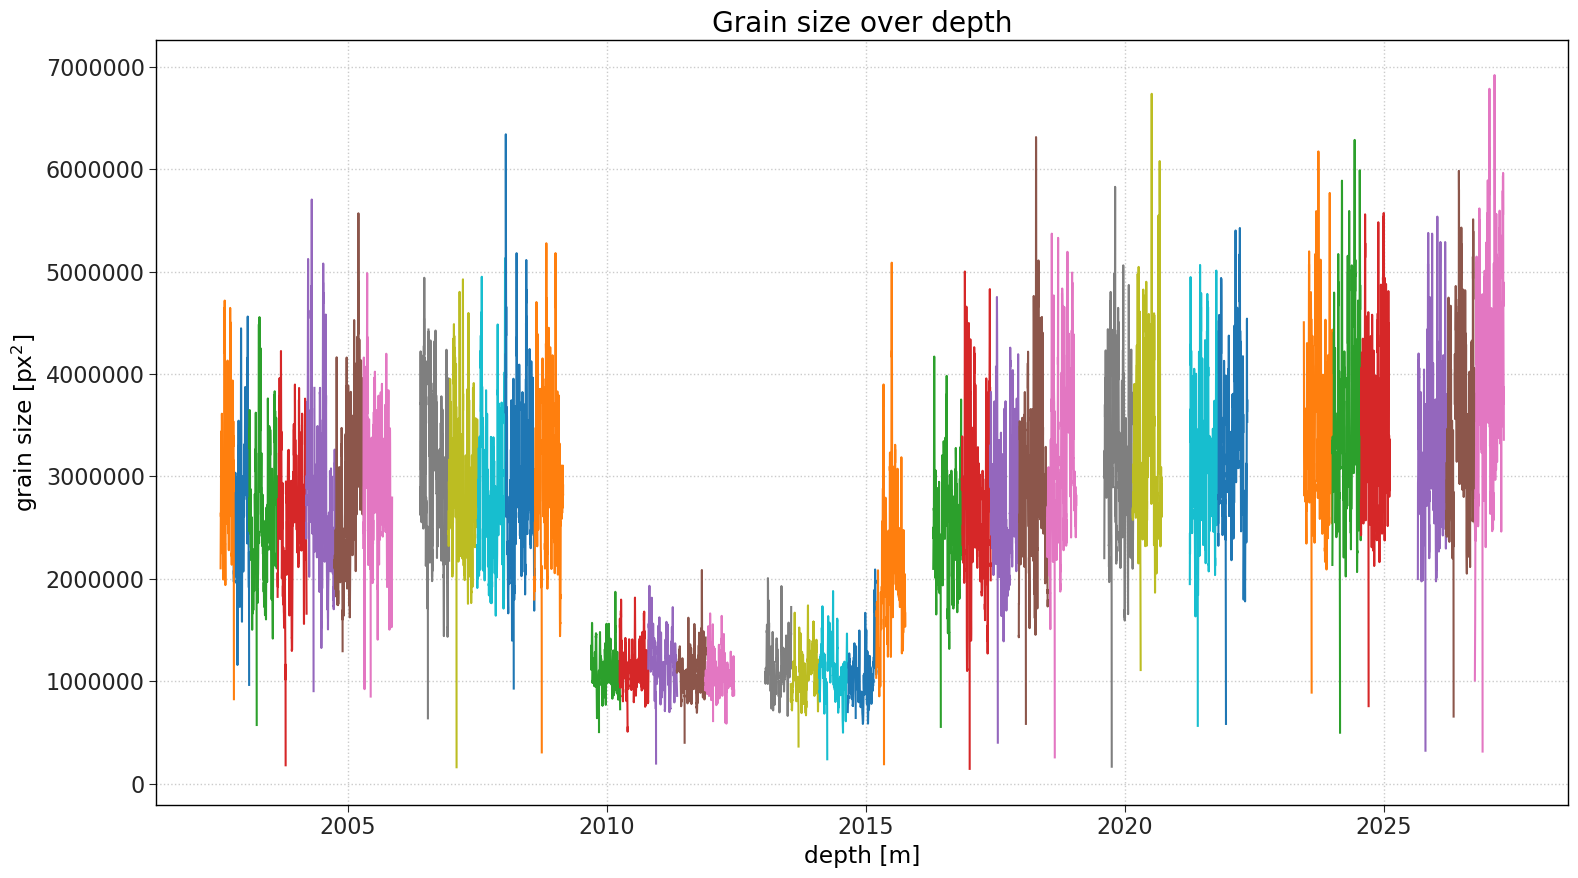

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

ax.ticklabel_format(useOffset=False, style="plain")

# Iterate over each bag in the df_sizes dictionary and plot its grain size over depth
for bag in list(df_sizes.keys()):
    # Ensure depth is in meters and grain size in px^2 for consistent scaling and labeling
    ax.plot(df_sizes[bag]["depth[m]"], df_sizes[bag]["grain_size[px]"], "-", label=bag)

ax.set(title="Grain size over depth", xlabel="depth [m]", ylabel="grain size [px$^2$]")
# ax.legend()  # Show legend to identify bags

fig.tight_layout()
# Optional: Uncomment to save the figure
# fig.savefig("Plots/6_grain_size_NEEM_bags.png", dpi=100)
plt.show()